# Notebook 01: Descarga de datos
### Detección de cambios urbanos en Viña del Mar (2019-2025)

Este notebook automatiza la descarga de imágenes satelitales Sentinel-2 y datos vectoriales censales/administrativos necesarios para el análisis multitemporal.

#### Resumen de Datos
A continuación se detallan los insumos geoespaciales que serán descargados y almacenados en la estructura del proyecto:

| Tipo de Dato | Archivo / Patrón | Ubicación Local | Fuente Original | Descripción Técnica |
| :--- | :--- | :--- | :--- | :--- |
| **Imágenes Satelitales** | `sentinel2_{AÑO}.tif` | `data/raw/` | **Google Earth Engine** (Copernicus S2 SR) | Mosaicos anuales generados mediante la mediana temporal. Resolución: 10m. |
| **Límite Administrativo** | `limite_comuna.gpkg` | `data/vector/` | **IDE Chile** (GeoPortal) | Polígono oficial de la División Político Administrativa (DPA 2020). |
| **Censo** | `manzanas_censales.shp` | `data/vector/` | **INE** (API ArcGIS) | Manzanas censales urbanas del Censo 2017 reproyectadas. |
| **Infraestructura** | `red_vial.geojson` | `data/vector/` | **OpenStreetMap** (OSMnx) | Red vial transitable para vehículos (layer 'drive'). |


> **Nota Técnica:** Para el formato Shapefile (`.shp`) del archivo de manzanas censales, la descarga incluye automáticamente sus archivos auxiliares obligatorios (`.shx`, `.dbf`, `.prj`, `.cpg`) para garantizar la integridad geométrica y de atributos.

---

#### Justificación del Área y Período de Estudio
* **Zona de Estudio:** Comuna de **Viña del Mar**, Región de Valparaíso, Chile.
    * *Justificación:* Viña del Mar presenta una dinámica urbana compleja, caracterizada por una rápida expansión inmobiliaria, presión sobre áreas verdes y alta vulnerabilidad ante desastres (incendios forestales que ocurrieron en el pasado). Es un caso de estudio ideal para monitorear la pérdida de vegetación y el crecimiento urbano.
* **Período de Análisis (2019-2025):**
    * *Justificación:* Este intervalo temporal de 7 años permite capturar efectos de mediano plazo derivados de eventos socioambientales críticos:
        1.  **Estallido Social (2019):** Cambios en dinámicas de movilidad y uso del espacio.
        2.  **Pandemia COVID-19 (2020-2021):** Alteración en patrones de desarrollo urbano y posibles cambios en la cobertura vegetal por menor actividad humana.
        3.  **Megasequía y Incendios (2024):** El periodo incluye el gran incendio de febrero de 2024, permitiendo evaluar su huella territorial en la imagen de 2025.

---

#### Metodología de adquisición de imágenes (Sentinel-2)
Para asegurar que los cambios detectados sean reales y no artefactos atmosféricos o estacionales, se implementó el siguiente protocolo en el script `download_sentinel.py`:

1. **Ventana temporal (Verano):** Se seleccionaron únicamente imágenes capturadas entre el **01 de Enero y el 30 de Marzo** de cada año. Lo que corresponde en mayoría a Verano y un pequeño lapso de Otoño.
* **Justificación:**
    * **Estabilidad fenológica:** En verano, la vegetación nativa de la zona central (esclerófila) presenta su menor actividad fotosintética, mientras que la vegetación urbana (irrigada) se mantiene verde. Esto maximiza el contraste espectral entre lo construido y lo natural.
    * **Cielos despejados:** Es la época con menor probabilidad histórica de cobertura nubosa en la costa central de Chile.

2. **Criterio de nubosidad (< 30%):** Se descartaron todas las escenas individuales (granules) que superaran el **30% de nubosidad**.
* **Justificación:** Aunque lo ideal es 0%, en zonas costeras como Viña del Mar la vaguada costera es frecuente. Un umbral de 30% es un balance técnico, ya que permite tener suficientes imágenes para crear un mosaico válido sin introducir demasiado ruido atmosférico que los algoritmos de corrección no puedan manejar. Además, hubo ciertos problemas con umbrales más bajos en las imágenes sentinel del año 2021 en Viña del Mar.
    * **Nivel de procesamiento:** **Surface Reflectance (SR)** (corregidas atmosféricamente).

3. **Reducción por mediana (Median Composite):** En lugar de elegir una sola imagen "perfecta" (que rara vez existe), se generó una imagen sintética anual calculando la **mediana** de cada píxel a través de todas las imágenes válidas del verano.
* **Justificación:** La mediana es un estimador robusto ante valores extremos (outliers).
    * Si un píxel tiene una nube brillante en la Imagen A y una sombra oscura en la Imagen B, pero es vegetación en las Imágenes C, D y E, la mediana seleccionará el valor de vegetación.
    * Esto permite "borrar" nubes y sombras residuales de forma estadística, entregando un mosaico limpio y continuo.
    * *Ventaja:* Elimina valores atípicos, sombras de nubes y píxeles defectuosos, generando una imagen "limpia" y representativa del año.

4. **Bandas espectrales:** Se descargaron las bandas B2 (Blue), B3 (Green), B4 (Red), B8 (NIR), B11 (SWIR1) y B12 (SWIR2).

---

#### Metodología de datos vectoriales:
La descarga de vectores (`download_vectors.py`) implementó estrategias de **resiliencia (fallback)** para asegurar la continuidad del proyecto incluso si las fuentes oficiales fallan:
1.  **Límites comunales:** Se intenta descarga directa desde **IDE Chile**. Si el servidor falla (común en portales gubernamentales), el script cambia automáticamente a un respaldo en **Google Drive** o, en última instancia, reconstruye el límite usando **OpenStreetMap**.
2.  **Manzanas censales:** Se consulta la **API REST de ArcGIS** del INE. El script normaliza el nombre de la comuna (quita tildes, mayúsculas) para evitar errores de consulta SQL y reproyecta automáticamente de WGS84 a **UTM Zona 19S** para coincidir con las imágenes satelitales.
3.  **Red vial:** Se descargó directamente de **OpenStreetMap**.

---
#### Comandos de descarga:

- Para descargar las imágenes Sentinel-2: `python scripts/download_sentinel.py`
- Para descargar todos los datos vectoriales (por defecto): `python scripts/download_vectors.py`
- Para descargar todos los datos vectoriales: `python scripts/download_vectors.py --sources all`
- Para descargar solo límites comunales: `python scripts/download_vectors.py --sources ide`
- Para descargar solo manzanas censales: `python scripts/download_vectors.py --sources ine`
- Para descargar solo red vial: `python scripts/download_vectors.py --sources osm`

---
#### Metadatos de los archivos descargados:

1. **Serie satelital Sentinel-2:** Se descargaron 7 imágenes (2019 a 2025) que comparten estrictamente los mismos parámetros de adquisición, garantizando que cualquier cambio detectado corresponda a variaciones en el territorio y no a diferencias en el sensor.
- **Constelación:** Sentinel-2 (Colección COPERNICUS/S2_SR_HARMONIZED). El uso de la colección Harmonized es crítico ya que corrige el desplazamiento radiométrico introducido por la ESA en enero de 2022, permitiendo comparar píxeles de 2019 con 2025 sin sesgos.
- **Ventana Estacional:** 01 Enero - 30 Marzo (Verano austral, aunque se considera un poco de Otoño). Todas las imágenes representan la fenología de verano, maximizando la detección de vegetación y suelo urbano.
- **Procesamiento:** Cloud Masking y Median Composite. El método de reducción por mediana fue exitoso bajo el umbral de <30% de nubosidad, generando mosaicos libres de nubes.
- **Resolución Espectral:** Bandas Visibles (10m): B2 (Blue), B3 (Green), B4 (Red). Y bandas Infrarrojas (10-20m): B8 (NIR), B11 (SWIR1), B12 (SWIR2).

2. **Validación de Datos Vectoriales:** Se han integrado exitosamente tres fuentes oficiales distintas, logrando una alineación espacial perfecta mediante la reproyección automática.

| Archivo | Fuente Original | CRS Original (Detectado) | CRS Final (Estandarizado) | Uso en el Proyecto |
| :--- | :--- | :--- | :--- | :--- |
| `limite_comuna.gpkg` | IDE Chile | WGS 84 (EPSG:4326) | **UTM 19S (EPSG:32719)** | Máscara de recorte principal. |
| `manzanas_censales.shp` | INE (API) | WGS 84 (EPSG:4326) | **UTM 19S (EPSG:32719)** | Unidad mínima para análisis de población expuesta. |
| `red_vial.geojson` | OpenStreetMap | WGS 84 (Lat/Lon) | **UTM 19S (EPSG:32719)** | Análisis de infraestructura y accesibilidad. |

##### 1) Configuración del entorno de trabajo

Este bloque importa las librerías necesarias y configura los directorios de salida para almacenar figuras, mapas y reportes del proyecto.

In [5]:
# =============================================================================
# CONFIGURACIÓN DEL ENTORNO DE TRABAJO
# =============================================================================
import os       # Para el manejo de variables de entorno y sistema operativo
import sys      # Para la manipulación de la ruta de módulos del sistema
# --- Importación de librerías geoespaciales ---
import geopandas as gpd         # Para el procesamiento de datos vectoriales (shapefiles, geojson, gpkg)
import rasterio                 # Para la lectura y escritura de datos raster (imágenes satelitales)
from rasterio.plot import show  # Para la visualización rápida de rasters con matplotlib
# --- Importación de librerías de visualización ---
import matplotlib.pyplot as plt  # Para la creación de gráficos y mapas estáticos

# --- Importación de utilidades ---
from pathlib import Path  # Para el manejo moderno y multiplataforma de rutas de archivos

# --- Configuración del directorio raíz del proyecto ---
# Se sube un nivel desde la carpeta notebooks/ para acceder a la raíz del proyecto
project_root = Path("..").resolve()
# Se agrega al path de Python para poder importar módulos propios del proyecto
sys.path.append(str(project_root))

print(f"Directorio raíz del proyecto: {project_root}")

# --- Configuración de directorios de salida ---
# Diccionario con las rutas donde se guardarán los productos del análisis
output_dirs = {
    "figures": project_root / "outputs" / "figures",  # Gráficos estadísticos
    "maps":    project_root / "outputs" / "maps",     # Mapas temáticos
    "reports": project_root / "outputs" / "reports"   # Tablas y reportes CSV
}

# --- Creación automática de carpetas si no existen ---
for name, path in output_dirs.items():
    path.mkdir(parents=True, exist_ok=True)  # parents=True crea carpetas intermedias
    print(f"✔ Directorio verificado: {path}")

Directorio raíz del proyecto: D:\laboratorio_cambio_urbano
✔ Directorio verificado: D:\laboratorio_cambio_urbano\outputs\figures
✔ Directorio verificado: D:\laboratorio_cambio_urbano\outputs\maps
✔ Directorio verificado: D:\laboratorio_cambio_urbano\outputs\reports


##### 2) Ejecución de scripts de descarga (Sentinel y vectores)

Esta celda ejecuta los scripts que descargan automáticamente:
1. Datos vectoriales (límites comunales, manzanas censales, red vial)
2. Imágenes satelitales Sentinel-2 (2019-2025) desde Google Earth Engine

In [6]:
# --- Descarga de datos vectoriales ---
# Script: download_vectors.py
# Fuentes: IDE Chile (límites), INE (censo), OpenStreetMap (vías)
# Parámetro --sources all: descarga todas las fuentes disponibles
print("--- Verificando Vectores ---")
!python ../scripts/download_vectors.py --sources all

# --- Descarga de imágenes Sentinel-2 ---
# Script: download_sentinel.py
# Fuente: Google Earth Engine (Copernicus S2 SR Harmonized)
# Período: Enero-Marzo de cada año (2019-2025) para maximizar cielos despejados
# Procesamiento: Compuesto mediano temporal con máscara de nubes
print("\n--- Verificando Imágenes Sentinel-2 ---")
!python ../scripts/download_sentinel.py

--- Verificando Vectores ---
➤ Ejecutando descarga de vectores. Modo: ALL
✔ [IDE] Límite comunal ya existe. Saltando...
✔ [INE] Manzanas censales ya existen. Saltando...
✔ [OSM] Red vial ya existe. Saltando...

✔ ✔ Proceso finalizado. Metadatos en: D:\laboratorio_cambio_urbano\data\vector\metadata.txt

--- Verificando Imágenes Sentinel-2 ---
Los datos se guardarán en: D:\laboratorio_cambio_urbano\data\raw
 Conectando a GEE con proyecto: composed-augury-451119-b6...
✔ GEE inicializado.
➤  Iniciando descarga oficial desde GEE...

✔ [YA EXISTE] sentinel2_2019.tif
✔ [YA EXISTE] sentinel2_2020.tif
✔ [YA EXISTE] sentinel2_2021.tif
✔ [YA EXISTE] sentinel2_2022.tif
✔ [YA EXISTE] sentinel2_2023.tif
✔ [YA EXISTE] sentinel2_2024.tif
✔ [YA EXISTE] sentinel2_2025.tif

✔ ✔ Proceso finalizado. Metadatos en: D:\laboratorio_cambio_urbano\data\raw\metadata.txt


##### 3) Validación visual de datos vectoriales

Genera un mapa compuesto que superpone las tres capas vectoriales descargadas:
- Límite comunal de Viña del Mar (polígono rojo)
- Manzanas censales del INE (áreas celestes)
- Red vial de OpenStreetMap (líneas grises)

Además, el mapa se guarda automáticamente en outputs/maps/

##### Análisis del mapa de datos vectoriales

1. **Delimitación administrativa (límite rojo):** El polígono administrativo (de la fuente DPA 2020) define la extensión total de la comuna de Viña del Mar. En este se observa claramente que la comuna no es solo su borde costero, pues posee una gran extensión territorial hacia el interior (este/sureste) que corresponde a zonas de interfaz urbano-rural, plantaciones forestales y reservas naturales, las cuales son zonas críticas para el análisis de incendios.

2. **Distribución de manzanas censales (polígonos celestes):** Las manzanas (de la fuente Censo 2017) actúan como un aproximado de la huella urbana consolidada. En estas se distingue claramente el contraste entre zonas como la Población Vergara (zona costera central), frente a la trama orgánica de los cerros (como la zona de Reñaca Alto). Además, se observan vacíos territoriales, ya que hay áreas dentro del límite rojo que no tienen manzanas celestes, las cuales se concentran en la parte sur de Viña del Mar, y corresponden a suelo no urbanizado (como vegetación, cerros, cuerpos de agua).

3. **Red vial (líneas grises):** La capa de vialidad (de la fuente OpenStreetMap) muestra una alta correlación con las manzanas censales, validando la precisión posicional. En ella se observa cómo la red vial estructura el crecimiento de la ciudad, extendiéndose hacia sectores periféricos (en rutas como Camino Las Palmas), lo cual es un indicador clásico de expansión urbana dispersa.


✔ Cargando vectores...


C:\Users\Carloto\AppData\Roaming\Python\Python312\site-packages\geopandas\io\file.py:576: UserWarning: Could not parse column 'reversed' as JSON; leaving as string
  return pyogrio.read_dataframe(path_or_bytes, bbox=bbox, **kwargs)


✘ Red Vial estaba en EPSG:4326. Reproyectando...
✔ Todos los vectores alineados en EPSG:32719.
✔ Mapa guardado exitosamente en: D:\laboratorio_cambio_urbano\outputs\maps\01_validacion_vectores.png


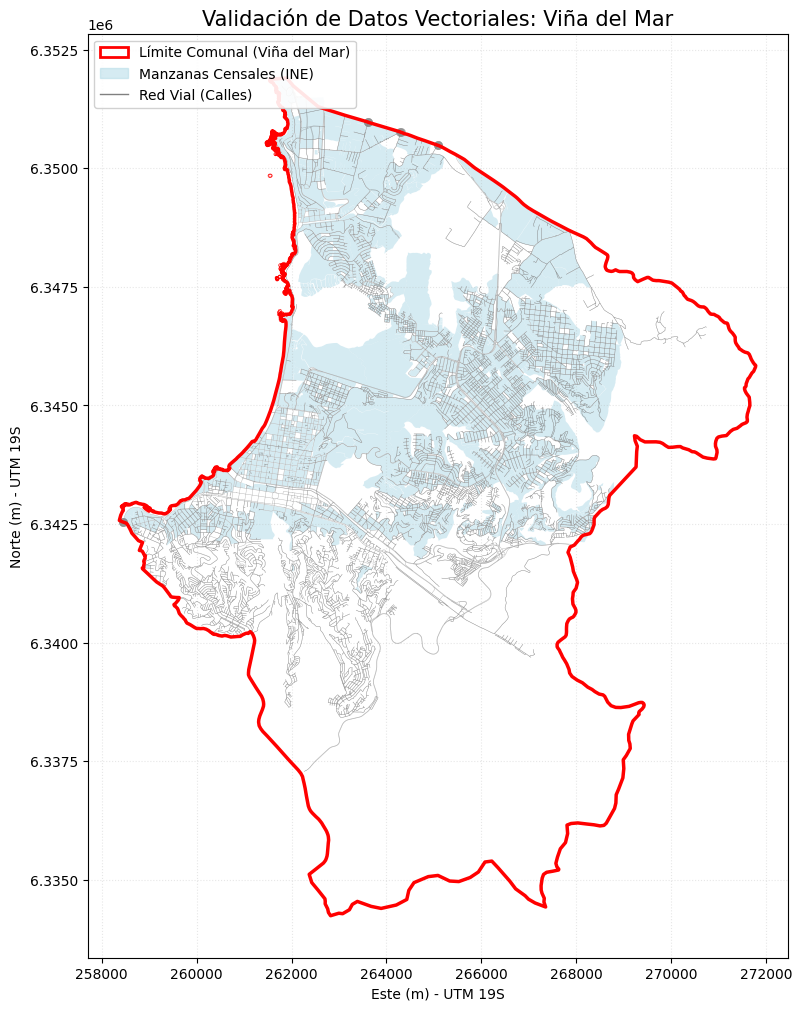

In [7]:
# =============================================================================
# VALIDACIÓN VISUAL DE DATOS VECTORIALES
# =============================================================================

# --- Importación de componentes adicionales de matplotlib para la leyenda ---
import matplotlib.patches as mpatches  # Parches para elementos de leyenda tipo polígono
import matplotlib.lines as mlines      # Líneas para elementos de leyenda tipo línea

# --- Definición de rutas de entrada para los vectores ---
vector_dir = project_root / "data" / "vector"
limite_path = vector_dir / "limite_comuna.gpkg"      # Límite comunal (GeoPackage)
manzanas_path = vector_dir / "manzanas_censales.shp" # Manzanas del censo (Shapefile)
vias_path = vector_dir / "red_vial.geojson"          # Red vial (GeoJSON)

try:
    # --- 1. Carga de datos vectoriales en memoria ---
    print("✔ Cargando vectores...")
    gdf_limite = gpd.read_file(limite_path)    # Lee el límite comunal
    gdf_manzanas = gpd.read_file(manzanas_path) # Lee las manzanas censales
    gdf_vias = gpd.read_file(vias_path)         # Lee la red vial

    # --- 2. Reproyección a sistema de coordenadas común (UTM 19S) ---
    # EPSG:32719 es el sistema UTM zona 19 Sur, adecuado para Chile central
    target_crs = "EPSG:32719"
    # Reproyecta cada capa si no está en el CRS objetivo
    if gdf_limite.crs.to_string() != target_crs: gdf_limite = gdf_limite.to_crs(target_crs)
    if gdf_manzanas.crs.to_string() != target_crs: gdf_manzanas = gdf_manzanas.to_crs(target_crs)
    if gdf_vias.crs.to_string() != target_crs:
        print(f"✘ Red Vial estaba en {gdf_vias.crs}. Reproyectando...")
        gdf_vias = gdf_vias.to_crs(target_crs)

    print("✔ Todos los vectores alineados en EPSG:32719.")

    # --- 3. Recorte de la red vial al límite comunal ---
    # Elimina segmentos de calles fuera del área de estudio
    try:
        gdf_vias = gpd.clip(gdf_vias, gdf_limite)
    except:
        pass  # Si falla el recorte, continúa con las vías sin recortar

    # --- 4. Creación de la figura y visualización de capas ---
    fig, ax = plt.subplots(figsize=(12, 12))  # Figura cuadrada de 12x12 pulgadas
    
    # Capa 1: Manzanas censales (fondo celeste semi-transparente)
    gdf_manzanas.plot(ax=ax, color='lightblue', alpha=0.5, zorder=1)
    # Capa 2: Red vial (líneas grises delgadas)
    gdf_vias.plot(ax=ax, color='gray', linewidth=0.3, alpha=0.6, zorder=2)
    # Capa 3: Límite comunal (borde rojo sin relleno, encima de todo)
    gdf_limite.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2.5, zorder=3)

    # --- 5. Construcción de la leyenda personalizada ---
    leyenda_elementos = [
        mpatches.Patch(facecolor='none', edgecolor='red', linewidth=2, label='Límite Comunal (Viña del Mar)'),
        mpatches.Patch(color='lightblue', alpha=0.5, label='Manzanas Censales (INE)'),
        mlines.Line2D([], [], color='gray', linewidth=1, label='Red Vial (Calles)')
    ]
    ax.legend(handles=leyenda_elementos, loc='upper left', fontsize=10, frameon=True, framealpha=0.9)

    # --- 6. Ajustes estéticos del mapa ---
    ax.set_aspect('equal')  # Mantiene la proporción geográfica correcta
    plt.title("Validación de Datos Vectoriales: Viña del Mar", fontsize=15)
    plt.xlabel("Este (m) - UTM 19S")   # Etiqueta eje X (coordenadas Este)
    plt.ylabel("Norte (m) - UTM 19S")  # Etiqueta eje Y (coordenadas Norte)
    plt.grid(True, linestyle=':', alpha=0.3)  # Grilla punteada suave
    
    # --- 7. Guardado automático del mapa ---
    output_filename = "01_validacion_vectores.png"
    save_path = output_dirs["maps"] / output_filename
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Alta resolución para informe
    print(f"✔ Mapa guardado exitosamente en: {save_path}")
    
    plt.show()  # Muestra el mapa en el notebook

except Exception as e:
    print(f"✘ Error visualizando: {e}")

##### 4) Visualización de la serie temporal de Sentinel-2 (Vegetación en Viña del Mar)

Genera un panel de control visual con todas las imágenes satelitales descargadas. En donde cada imagen se recorta (mask) al límite comunal y se visualiza la banda NIR (B8) que resalta la vegetación, lo que permite verificar la calidad de las descargas y detectar anomalías antes del procesamiento posterior (cálculo de índices).

##### Análisis de vegetación en Viña del Mar:

1. **Interpretación de colores:**

- **Amarillo:** Indica alta reflectancia en el infrarrojo cercano. Esto corresponde casi exclusivamente a vegetación fotosintéticamente activa (como bosques, parques regados, canchas de golf).
- **Verde/turquesa:** Valores medios. Suelen ser zonas de transición, vegetación más dispersa o matorral seco.
- **Azul oscuro/morado:** Valores bajos de reflectancia NIR. Esto representa superficies impermeables (ciudad, asfalto, edificios), suelo desnudo o agua (mar, lagunas).

2. **Dinámica temporal (análisis superficial):**

- **Estabilidad Urbana:** Hay pequeñas manchas urbanas centrales (zona costera y plan) que se mantienen consistentemente en tonos oscuros (morado/azul), indicando que es una zona consolidada sin grandes cambios de cobertura vegetal.
- **Variabilidad en periferia:** Se observan cambios sutiles en los tonos amarillos hacia los bordes de la comuna (cerros).
- **Impacto de incendios ocurridos en 2024:** Si se compara la imagen de 2023 con la de 2025 (post-incendio), se puede observar una disminución de zonas amarillas en el sector sureste y en general (como en el Jardín Botánico), transformándose en tonos más oscuros o verdosos, lo que visualmente confirma la pérdida de biomasa. Además, en 2024 se ve una gran concentración de tonos azules en la zona sur, lo que pudo ser consecuencia directa de los incendios ocurridos en ese año.

✔ Encontradas 7 imágenes. Generando panel de control...
✔ Figura guardada exitosamente en: D:\laboratorio_cambio_urbano\outputs\maps\01_serie_temporal_sentinel.png


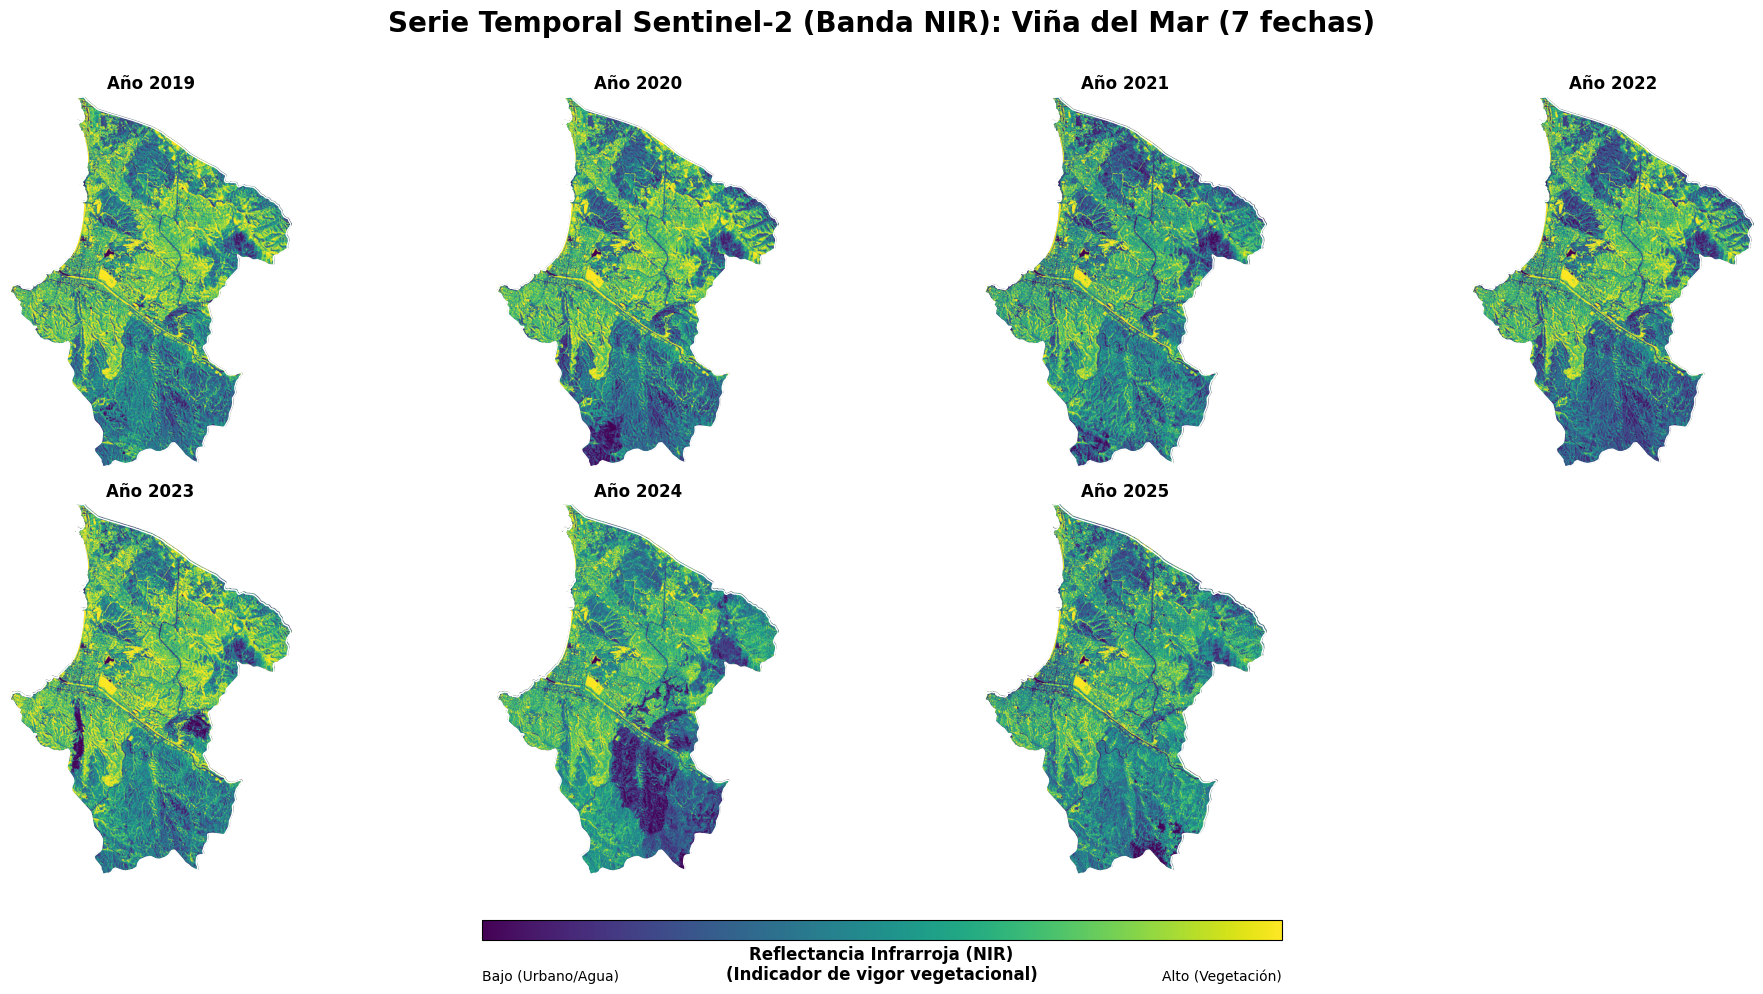

In [9]:
# =============================================================================
# VISUALIZACIÓN DE SERIE TEMPORAL SENTINEL-2
# =============================================================================
# --- Importación de librerías adicionales ---
import numpy as np                # Operaciones numéricas con arrays
import matplotlib.pyplot as plt   # Visualización de gráficos
from rasterio.plot import show    # Visualización de rasters
from rasterio.mask import mask    # Recorte de rasters con geometrías vectoriales

# --- Configuración de rutas de entrada ---
raw_dir = project_root / "data" / "raw"  # Directorio con imágenes Sentinel-2
# Lista ordenada de todas las imágenes .tif que coinciden con el patrón sentinel2_*.tif
imagenes = sorted(list(raw_dir.glob("sentinel2_*.tif")))

# --- Carga del límite comunal para recorte ---
vector_path = project_root / "data" / "vector" / "limite_comuna.gpkg"
gdf_limite = gpd.read_file(vector_path)

# --- Verificación de existencia de imágenes ---
if not imagenes:
    print("✘ No hay imágenes.")
else:
    print(f"✔ Encontradas {len(imagenes)} imágenes. Generando panel de control...")

    # --- Configuración del panel de visualización (2 filas x 4 columnas) ---
    cols = 4  # Número de columnas en el panel
    rows = 2  # Número de filas en el panel
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    axes = axes.flatten()  # Convierte matriz 2D de ejes en lista 1D para iteración fácil

    # --- Iteración sobre cada imagen satelital ---
    for idx, img_path in enumerate(imagenes):
        ax = axes[idx]  # Selecciona el subplot correspondiente
        year = img_path.stem.split("_")[1]  # Extrae el año del nombre del archivo
        
        # --- Apertura y procesamiento del raster ---
        with rasterio.open(img_path) as src:
            # Reproyecta el vector si tiene CRS diferente al raster
            if gdf_limite.crs != src.crs:
                gdf_limite = gdf_limite.to_crs(src.crs)
            
            # --- Recorte espacial (masking) al límite comunal ---
            shapes = [geom for geom in gdf_limite.geometry]  # Lista de geometrías
            out_image, out_transform = mask(src, shapes, crop=True)  # Recorta y ajusta
            
            # --- Extracción de banda NIR (índice 3 = B8) ---
            # La banda NIR resalta vegetación (valores altos) vs áreas construidas (bajos)
            nir = out_image[3].astype(float)
            
            # --- Limpieza de valores inválidos ---
            nir[nir <= 0] = np.nan    # Reemplaza valores negativos/cero con NaN
            nir[np.isinf(nir)] = np.nan  # Reemplaza infinitos con NaN
            
            # --- Visualización con estiramiento de contraste ---
            if np.nanmax(nir) > 0:  # Solo si hay datos válidos
                # Calcula percentiles 2 y 98 para estiramiento de contraste
                vmin, vmax = np.nanpercentile(nir, [2, 98])
                # Renderiza el raster con paleta de colores 'viridis'
                # Guardamos el objeto 'im' para usarlo en la barra de color después
                im = show(nir, transform=out_transform, ax=ax, cmap='viridis', 
                          vmin=vmin, vmax=vmax)
                ax.set_title(f"Año {year}", fontsize=12, fontweight='bold')
                # Superpone el límite comunal como contorno blanco
                gdf_limite.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=1)
            else:
                ax.set_title(f"{year} (VACÍA)", color='red')  # Indica imagen sin datos
            
            # --- Limpieza de ejes para mejor visualización ---
            ax.set_axis_off() # Quita ejes X/Y por completo
            
    # --- Eliminación de subplots vacíos (si hay menos de 8 imágenes) ---
    for i in range(len(imagenes), rows * cols):
        fig.delaxes(axes[i])

    # --- Ajustes finales del layout ---
    # Dejamos más espacio arriba (top) para el título y abajo (bottom) para la barra
    plt.tight_layout(rect=[0, 0.1, 1, 0.93])

    # --- AGREGAR BARRA DE COLOR (LEYENDA) ---
    # Usamos la última imagen ploteada ('im') como referencia de color
    # show() de rasterio retorna un AxesImage, accedemos a él via ax.images
    # Crea un eje nuevo en la parte inferior para la barra
    cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02]) # [left, bottom, width, height]
    if axes[0].images:
        cbar = plt.colorbar(axes[0].images[0], cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Reflectancia Infrarroja (NIR)\n(Indicador de vigor vegetacional)', fontsize=12, fontweight='bold')
        # Limpiamos los números y ponemos texto descriptivo
        cbar.set_ticks([]) 
        cbar.ax.text(0, -1.5, 'Bajo (Urbano/Agua)', ha='left', va='top', transform=cbar_ax.transAxes, fontsize=10)
        cbar.ax.text(1, -1.5, 'Alto (Vegetación)', ha='right', va='top', transform=cbar_ax.transAxes, fontsize=10)

    # Título General (más arriba con y=0.98 relativo al rect definido en tight_layout)
    plt.suptitle(f"Serie Temporal Sentinel-2 (Banda NIR): Viña del Mar ({len(imagenes)} fechas)", fontsize=20, fontweight='bold')
    
    # --- Guardado automático de la figura ---
    output_filename = "01_serie_temporal_sentinel.png"
    save_path = project_root / "data" / "raw" / output_filename # Guardar en data/raw por ahora o definir output_dirs
    if "output_dirs" in locals():
         save_path = output_dirs["maps"] / output_filename

    plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Alta resolución para informe
    print(f"✔ Figura guardada exitosamente en: {save_path}")
    
    plt.show()  # Muestra el panel en el notebook